# How do I get $\nu_{\rm max}$ and $\Delta\nu$ using an Autocorrelation Function (ACF)?

This is a quick guide a wrote for 3rd year Group Studies students at the University of Birmingham. It is based on the work presented in [Huber et al 2009](https://ui.adsabs.harvard.edu/#abs/arXiv:0910.2764), pretty much.

I'll be doing this backwards sorta, by finding $\Delta\nu$ first and then $\nu_{\rm max}$ after. Its easier to explain that way.

Whats the most beautiful long cadence lightcurve for a quick look? Probably KIC11615890

In [52]:
import lightkurve as lk
import matplotlib.pyplot as plt
import astropy.units as u
import numpy as np
import matplotlib
plt.style.use(lk.MPLSTYLE)
matplotlib.rcParams['text.usetex'] = False

In [2]:
datalist = lk.search_lightcurvefile('KIC11615890')
data = datalist.download_all()

We'll use lightkurve to get a signal-to-noise spectrum. In order to avoid bogging down too much memory I'll just grab 5 quarters of data. Using all the available data will of course dramatically improve your inferences.

/home/oliver/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


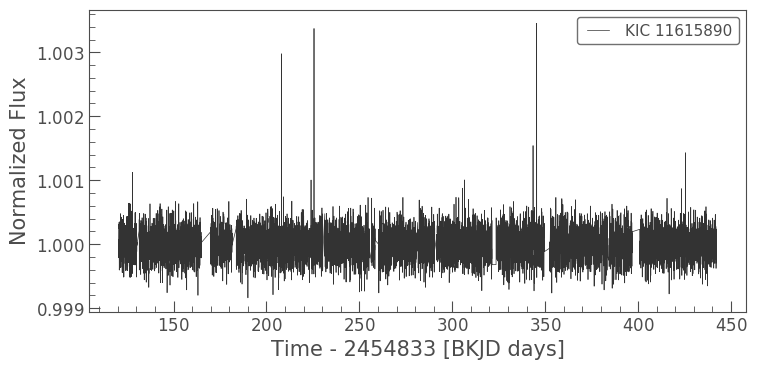

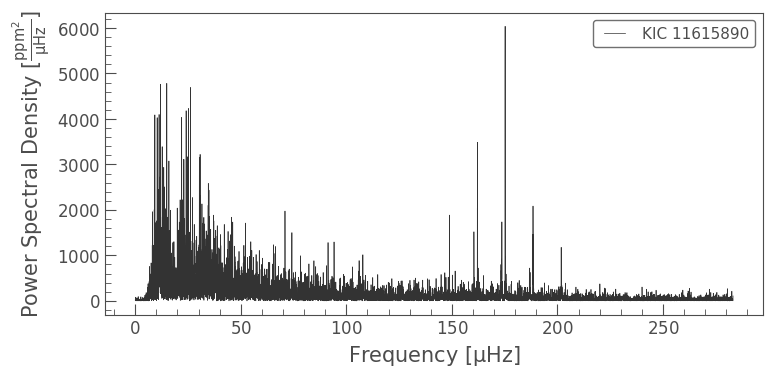

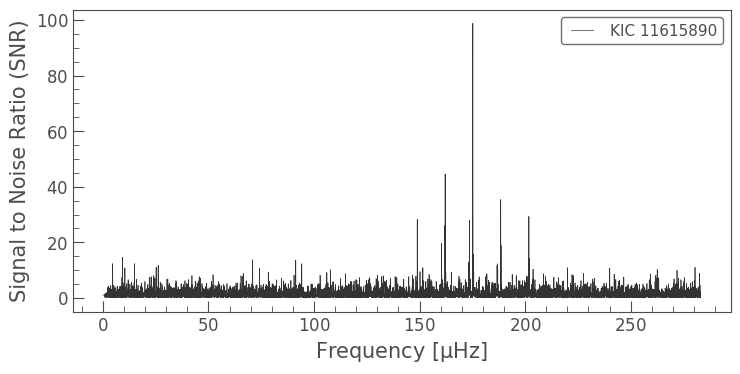

In [3]:
lc = data[0].PDCSAP_FLUX.normalize().flatten()
for nlc in data[0:5]: 
    lc = lc.append(nlc.PDCSAP_FLUX.normalize().flatten())
lc = lc.remove_nans()
lc.plot()
pg = lc.to_periodogram(freq_unit = u.microhertz)
pg.plot()
snr = pg.flatten()
snr.plot()

# Finding $\Delta\nu$ using autocorrelation (given a known $\nu_{\rm max}$!)

Resolution on this star is great, so we can go for $\delta\nu_{0,2}$ as well.

Lets assume a numax of ~175 $\mu\rm Hz$
We calculate the full-width-half-maximum (FWHM) of the mode envelope (this is a known empirical relation in the field). We then take one FWHM either side of our known $\nu_{\rm max}$, and then multiply this again with a **hanning window**, which is basically just a Gaussian in the shape of our mode envelope. This basically makes sure that if our $\nu_{\rm max}$ is wrong the autocorrelation is punished by reducing the power of the modes. For an accurate $\nu_{\rm max}$ this will make no difference.

In [39]:
numax = 175.
frequency_spacing = np.median(np.diff(snr.frequency)).value  #Find the median frequency spacing

#Calculate a full width half maximum
fwhm = int(np.floor(1.0 * 0.66 * numax**0.88 / frequency_spacing))
fwhm -= fwhm % 2                                    # Make the FWHM value even (%2 = 0 if even, 1 if odd)
    
x = int(numax / frequency_spacing)                  #Find the index value of numax
s = np.hanning(len(snr.power[x-fwhm:x+fwhm]))   #Define the hanning window for the evaluated frequency space

C = snr.power[x-fwhm:x+fwhm] * s                     #Multiply the evaluated SNR space by the hanning window

In blue below we see the data we're going to autocorrelate with itself:

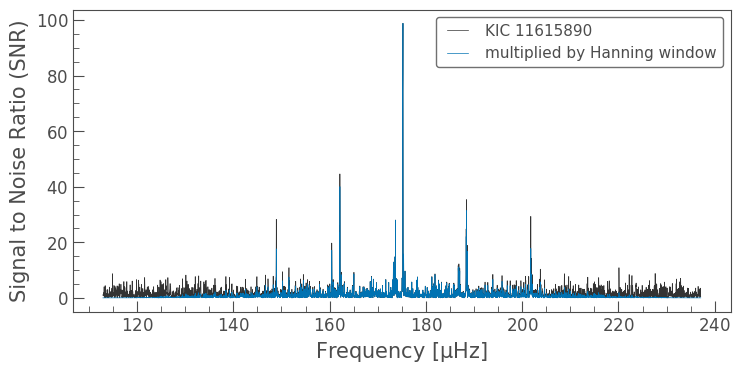

In [40]:
ax = snr[x-fwhm:x+fwhm].plot()
(snr[x-fwhm:x+fwhm]*s).plot(ax=ax, label='multiplied by Hanning window')

Now lets do the autocorrelation:

In [41]:
result = np.correlate(C, C, mode='full')             #Correlated the resulting SNR space with itself
acf = result[int(len(result)/2):]            

As you can maybe tell from the input to np.correlate(), it correlates our data C with our data C by shifting them over one another index-by-index and calculating the correlation at each shift. We sometimes call these shifts 'lag'.

Because it shifts index-by-index, our step resolution is equal to the frequency resolution.

Because its moving all of C over all of C, the resulting ACF is double the length of our array, and mirrored across the centre, so we throw away the first half of the ACF.

Lets create a grid of our 'lags' and plot the ACF!

Text(0, 0.5, 'Autocorrelation (units arbitrary)')

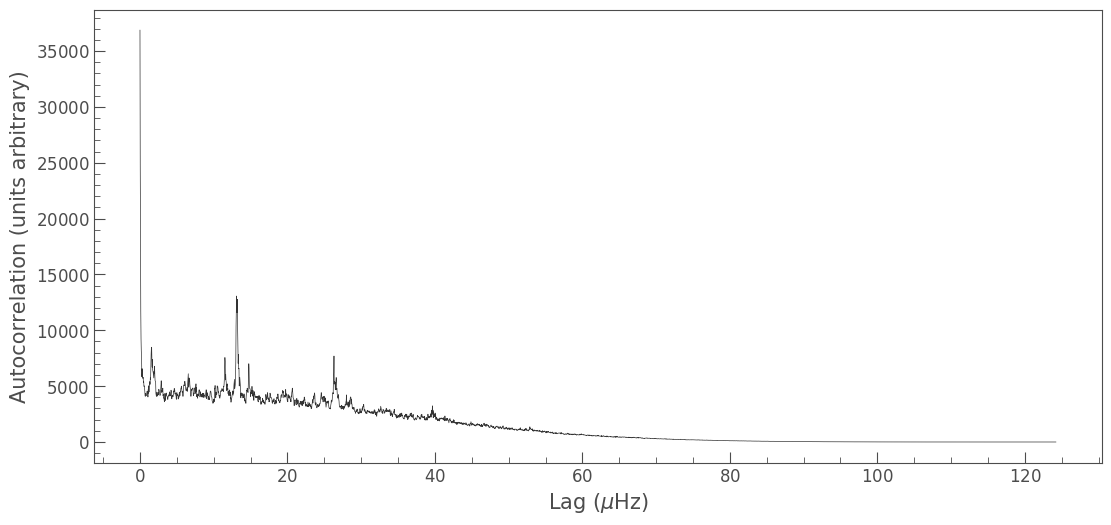

In [54]:
lags = np.linspace(0, len(acf)*frequency_spacing, len(acf))
fig, ax = plt.subplots(figsize=(13,6))
ax.plot(lags, acf)
ax.set_xlabel(r'Lag ($\mu \rm Hz$)')
ax.set_ylabel(r'Autocorrelation (units arbitrary)')

Alright, now lets break down the features in this ACF:

- The strong peak at the centre:
    This is the correlation of the data with itself at no shift. Naturally, this will be as high as it can go!
    
    
- The peak at ~1-2 $\mu \rm Hz$:
    This is actually the small separation! You can imagine that if you shift the spectrum over itself a tiny bit the $\mathscr{l}=0$ and $l=2$ peaks will overlap, causing this small spike in correlation.
    
    
- The trio of peaks at ~15 $\mu \rm Hz$: This is the large separation! the correlation will be largest here because of the $\mathscr{l}=0,2$ structure overlapping with the next harmonic of the $\mathscr{l}=0,2$ structure. The little peaks either side are due to the $\mathscr{l}=0$ peak overlapping with the $\mathscr{l}=2$ peak of the $\mathscr{l}=0,2$ structure on its way in, and on its way out. Notice how the correlation is similar to that we observed for the small separation!


- The trio of peaks at ~26 $\mu \rm Hz$ is the central $\mathscr{l}=0,2$ structure overlapping with the second harmonic along. The power is reduced because the mode powers are starting to look different the further we move away from the central frequency. This will be at $2*\Delta\nu$!


- The little peak at 40 $\mu \rm Hz$ is the overlap with the 3rd harmonic along... you get the picture. At this point the mode powers are so different that theres very little power.

So lets try and extract a $\Delta\nu$ and $\delta\nu_{0,2}$ out of this by eye:

Text(0, 0.5, 'Autocorrelation (units arbitrary)')

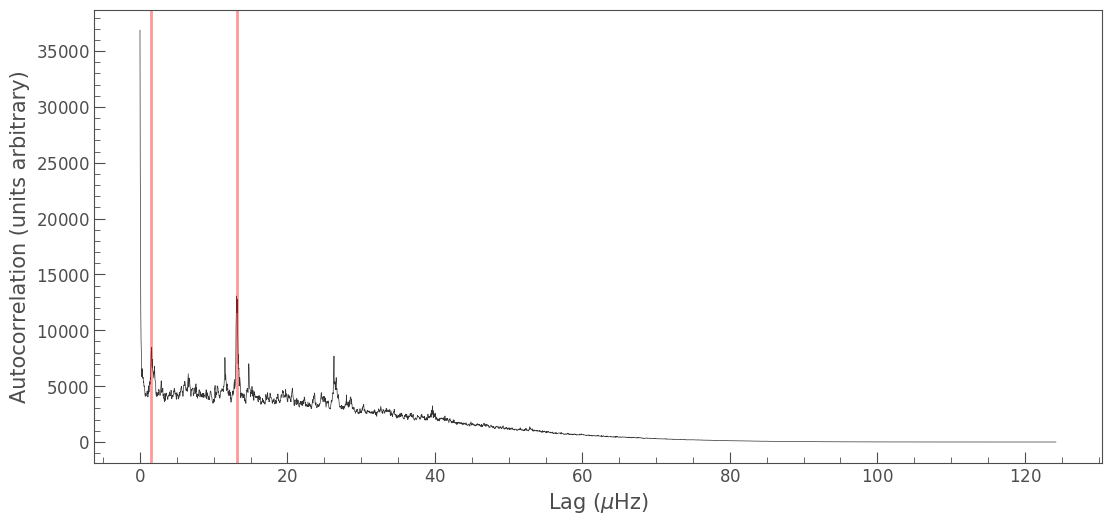

In [62]:
lags = np.linspace(0, len(acf)*frequency_spacing, len(acf))
fig, ax = plt.subplots(figsize=(13,6))
ax.plot(lags, acf)
ax.axvline(1.5,c='r', linewidth=2,alpha=.4)
ax.axvline(13.2,c='r', linewidth=2,alpha=.4)
ax.set_xlabel(r'Lag ($\mu \rm Hz$)')
ax.set_ylabel(r'Autocorrelation (units arbitrary)')

So $ \Delta\nu = 13.2\, \mu \rm Hz$ and $\delta\nu_{0,2} = 1.5\, \mu \rm Hz$.

If you want to quantify this properly, you could fit a Gaussian to the autocorrelation peak for these values, and take a spread on the fit. We dont have infinite resolution in frequency, there will naturally be some spread in the autocorrelation peaks!

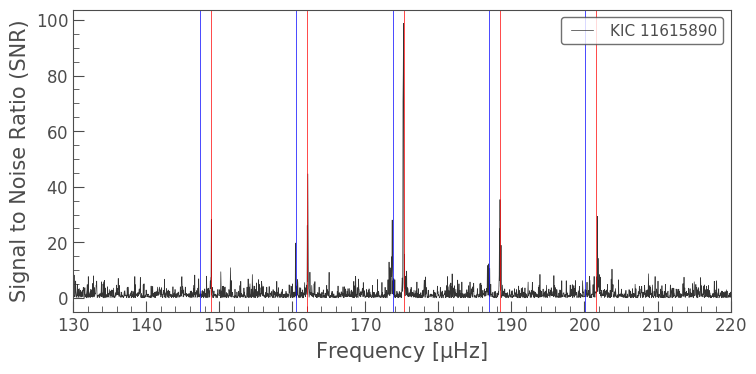

In [147]:
ax = snr.plot()
ax.set_xlim(130,220)
ax.axvline(snr.frequency[np.argmax(snr.power)].value, c='r')
ax.axvline(snr.frequency[np.argmax(snr.power)].value+13.2, c='r')
ax.axvline(snr.frequency[np.argmax(snr.power)].value+13.2*2, c='r')
ax.axvline(snr.frequency[np.argmax(snr.power)].value-13.2, c='r')
ax.axvline(snr.frequency[np.argmax(snr.power)].value-13.2*2, c='r')

ax.axvline(snr.frequency[np.argmax(snr.power)].value-1.5, c='b')
ax.axvline(snr.frequency[np.argmax(snr.power)].value+13.2-1.5, c='b')
ax.axvline(snr.frequency[np.argmax(snr.power)].value+13.2*2-1.5, c='b')
ax.axvline(snr.frequency[np.argmax(snr.power)].value-13.2-1.5, c='b')
ax.axvline(snr.frequency[np.argmax(snr.power)].value-13.2*2-1.5, c='b')

# Finding $\nu_{\rm max}$ with an ACF

Have a think about how you would do this to find a value for $\nu_{\rm max}$. What would the autocorrelation function look like if you choose a value of lets say, 50 $\mu \rm Hz$? If we took a FWHM around that area and multiplied it with our hanning window we would just get white noise! There would be not peaks in correlation at all. 

But when we hit the $\nu_{\rm max}$ sweet spot around the true value, the total power in our correlation function will start going up! So the trick is to cycle through different values for $\nu_{\rm max}$ and find the point at which the value is highest.

I'll run through this below:

In [18]:
def ACF(power, frequency_spacing, numax):
    '''Function calcluates the ACF for a given numax.
    Paramters:
        numax (float64): numax of the expected envelope.

    Returns:
        ndarray: the ACF calculated for the given numax
        ndarray: the area of the power spectrum for which the ACF was calculated,
                multiplied by an appropriate hanning window.
    '''
    #Calculate the index FWHM for a given numax
    fwhm = int(np.floor(1.0 * 0.66 * numax**0.88 / frequency_spacing))
    fwhm -= fwhm % 2                                    # Make the FWHM value even (%2 = 0 if even, 1 if odd)
    x = int(numax / frequency_spacing)                  #Find the index value of numax
    s = np.hanning(len(power[x-fwhm:x+fwhm]))   #Define the hanning window for the evaluated frequency space
    C = power[x-fwhm:x+fwhm] * s                     #Multiply the evaluated SNR space by the hanning window
    result = np.correlate(C, C, mode='full')            #Correlated the resulting SNR space with itself
    return result[int(len(result)/2):], C               #Return the ACF and the evaluated SNR space

This function is for plotting purposes: the FWHM is a function of $\nu_{max}$ so at lower values the autocorrelation section will be shorter. This makes sure they all go into an equal length array.

In [25]:
def max_acfspace(frequency_spacing, numaxs):
    maxval = numaxs.max()
    fwhm = int(np.floor(1.0 * 0.66 * maxval**0.88 / frequency_spacing))
    fwhm -= fwhm % 2
    return int(2*fwhm)

In [96]:
#Create our range of numax values (on a log scale, so we get better sampling around the true numax value)
numaxs = np.exp(np.linspace(np.log(10),np.log(snr.nyquist.value),200))

#Building the output arrays
maxacf = np.zeros(len(numaxs))
maxspace = max_acfspace(frequency_spacing, numaxs)
ACF_list = np.zeros((len(numaxs),maxspace))
power = snr.power.value

#Calculating the ACF for each numax in our list
for idx, numax in enumerate(numaxs):
    acf, C = ACF(power, frequency_spacing, numax)    #Calculate the ACF for a given numax
    #Find lower and upper estimates on dnu for a range of relevant masses

    #Append the ACF results for this numax and normalise them
    ACF_list[idx,:len(acf)] = acf/len(acf)

    sum_acf = np.sum(ACF_list[idx,:len(acf)])
    
    #Store the maximum value of the ACF
    maxacf[idx] = np.nanmax(acf)

So the loop above has calculated the ACF for 200 different values of $\nu_{\rm max}$! We can stack them side by side and plot them to give an idea of how the ACF changes given our chocie of $\nu_{\rm max}$: 

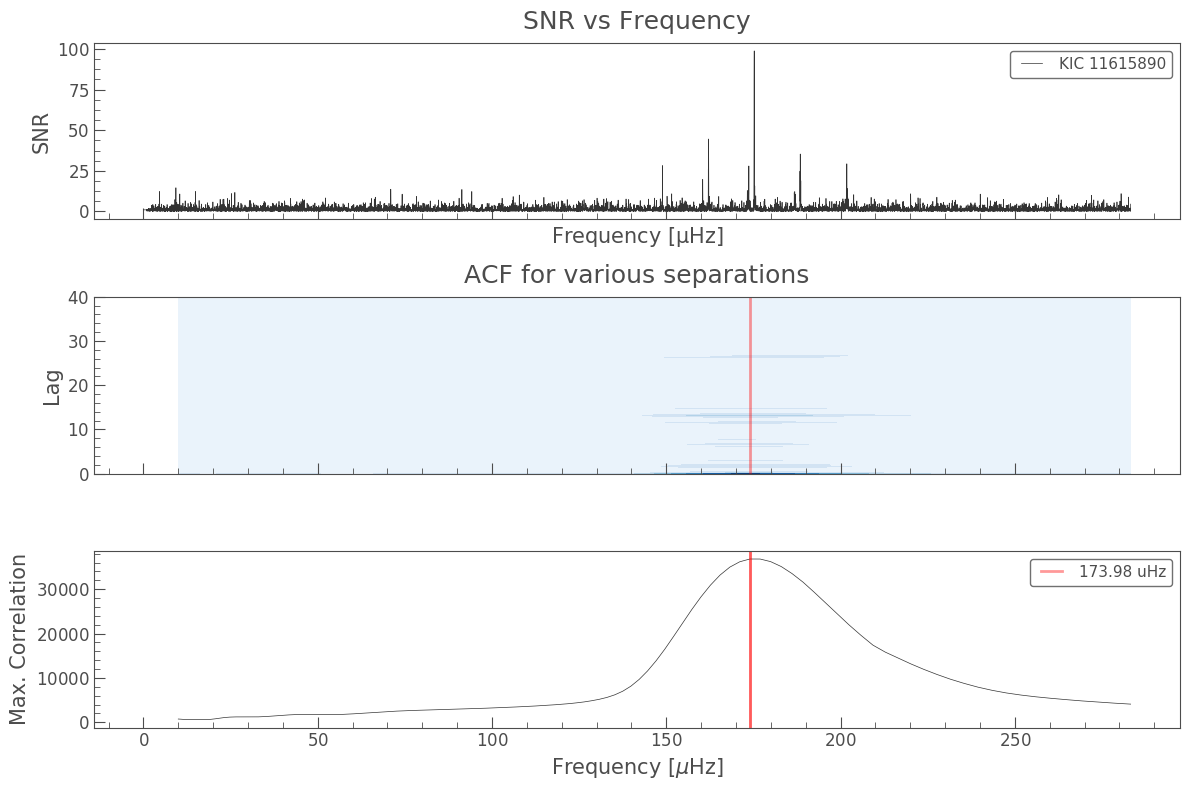

In [152]:
#WARNING: I'm hard coding in a limit here as to how far out we look at the lag.
#It becomes virtually pointless after a shift of 40 uHz, so I've capped it there. Makes the plot clearer
ylim = int(40/frequency_spacing)
lags = np.linspace(0,ylim*frequency_spacing,ylim)


xlim = int(numaxs.max()/frequency_spacing)

best_numax = numaxs[np.argmax(maxacf)]     #The best numax is the numax that results in the highest ACF

fig, ax = plt.subplots(3,sharex=True,figsize=(12,8))
snr[:xlim].plot(ax=ax[0])
ax[0].set_ylabel(r'SNR')
ax[0].set_title(r'SNR vs Frequency')

ax[1].contourf(numaxs,lags,ACF_list[:,:ylim].T,cmap='Blues')
ax[1].set_title(r'ACF for various separations')
ax[1].set_ylabel(r'Lag')

ax[2].plot(numaxs,maxacf)
ax[2].set_xlabel(r'Frequency [$\mu$Hz]')
ax[2].set_ylabel(r'Max. Correlation') 
ax[2].axvline(best_numax,c='r', linewidth=2,alpha=.4)
ax[1].axvline(best_numax,c='r', linewidth=2,alpha=.4)
ax[2].axvline(best_numax,c='r', linewidth=2,alpha=.4, label='{:.2f} uHz'.format(best_numax))
ax[2].legend()

plt.tight_layout()

Lets break these plots down one by one:
- Top: The SNR spectrum, nothing fancy here.


- Middle: This is a countourplot illustrating all 200 ACFs we have taken at different values of $\nu_{\rm max}$. The ACFS are arranged vertically (lag on the y axis) with frequency of $\nu_{\rm max}$ on the x-axis. The colour indicates power, which is relative and has been normalised for the different ACFs. Have a look back at our single ACF from before. Can you see how it translates to this image? You can reognised the various peaks coming in and out at different lags.


- Bottom: If you take the maximum value of the ACF at every value of $\nu{\rm max}$, we build up a distribution of how the ACF changes with $\nu_{\rm max}$. We take the maximum value of this, and we've found our value (the red line)!

As before, you can fit a Gaussian to this peak to get some form of uncertainty on the value. Looks like our initial guess of 175 wasn't too far off though!

### I hope this helped you understand autocorrelation functions to find asteroseismic parameters a bit better. This functionality will be built into `lightkurve`, at some stage!